In [1]:
import pandas as pd
import glob

path = "LoLesports_data"

all_files = glob.glob(path + "/*.csv")

df_list = []

for file in all_files[-3:]:
    temp_df = pd.read_csv(file, low_memory=False)
    df_list.append(temp_df)

df = pd.concat(df_list, ignore_index=True)
df = df[df["datacompleteness"] == "complete"]
df.drop(columns=["datacompleteness", "url"], inplace=True)

train = df[(df["patch"] >= 12.01) & (df["patch"] <= 14.05)]
test = df[df["patch"] >= 14.06]

train.shape, test.shape

((266040, 159), (67380, 159))

- 팀, 선수 데이터 분리

In [2]:
teams_train = train[train["position"] == "team"].reset_index(drop=True)
players_train = train[train["position"] != "team"].reset_index(drop=True)

teams_test = test[test["position"] == "team"].reset_index(drop=True)
players_test = test[test["position"] != "team"].reset_index(drop=True)

teams_train.shape, players_train.shape, teams_test.shape, players_test.shape

((44340, 159), (221700, 159), (11230, 159), (56150, 159))

- 팀 데이터 결측치 처리

In [3]:
drop_teams_cols = [
    "playername",
    "playerid",
    "position",
    "champion",
    "firstbloodkill",
    "firstbloodassist",
    "firstbloodvictim",
    "damageshare",
    "dragons (type unknown)",
    "earnedgoldshare",
    "total cs",
    "goldat20",
    "xpat20",
    "csat20",
    "opp_goldat20",
    "opp_xpat20",
    "opp_csat20",
    "golddiffat20",
    "xpdiffat20",
    "csdiffat20",
    "killsat20",
    "assistsat20",
    "deathsat20",
    "opp_killsat20",
    "opp_assistsat20",
    "opp_deathsat20",
    "goldat25",
    "xpat25",
    "csat25",
    "opp_goldat25",
    "opp_xpat25",
    "opp_csat25",
    "golddiffat25",
    "xpdiffat25",
    "csdiffat25",
    "killsat25",
    "assistsat25",
    "deathsat25",
    "opp_killsat25",
    "opp_assistsat25",
    "opp_deathsat25",
    "monsterkillsownjungle",
    "monsterkillsenemyjungle",
]

fill_zero_cols = [
    "game",
    "elementaldrakes",
    "opp_elementaldrakes",
    "chemtechs",
    "hextechs",
    "void_grubs",
    "opp_void_grubs",
    "turretplates",
    "opp_turretplates",
    "quadrakills",
    "pentakills",
    "heralds",
    "opp_heralds",
    "firstblood",
    "firstdragon",
    "dragons",
    "opp_dragons",
    "infernals",
    "mountains",
    "clouds",
    "oceans",
    "elders",
    "opp_elders",
    "firstherald",
    "firstbaron",
    "barons",
    "opp_barons",
    "firsttower",
    "firstmidtower",
    "inhibitors",
    "opp_inhibitors",
]

fill_unknown_cols = [
    "gameid",
    "teamname",
    "teamid",
    "ban1",
    "ban2",
    "ban3",
    "ban4",
    "ban5",
    "pick1",
    "pick2",
    "pick3",
    "pick4",
    "pick5",
    "split",
]

teams_train.drop(columns=drop_teams_cols, inplace=True)
teams_train[fill_zero_cols] = teams_train[fill_zero_cols].fillna(0)
teams_train[fill_unknown_cols] = teams_train[fill_unknown_cols].fillna("unknown")

In [4]:
missing_columns = teams_train.columns[teams_train.isnull().sum() > 0]
null_samples = teams_train[teams_train[missing_columns].isnull().any(axis=1)]

for idx, row in null_samples.iterrows():
    team_history = teams_train[
        (teams_train["teamid"] == row["teamid"])
        & (teams_train["gameid"] < row["gameid"])
    ].sort_values("gameid", ascending=False)

    for col in missing_columns:
        if pd.isnull(row[col]):
            prev_5_mean = team_history[col].head(5).mean()
            if pd.notnull(prev_5_mean):
                teams_train.loc[idx, col] = prev_5_mean
            else:
                teams_train.loc[idx, col] = teams_train[col].mean()

In [5]:
teams_train.shape

(44340, 116)

In [6]:
teams_train.isnull().sum().sum()

0

In [7]:
teams_test.drop(columns=drop_teams_cols, inplace=True)
teams_test[fill_zero_cols] = teams_test[fill_zero_cols].fillna(0)
teams_test[fill_unknown_cols] = teams_test[fill_unknown_cols].fillna("unknown")

missing_columns = teams_test.columns[teams_test.isnull().sum() > 0]
null_samples = teams_test[teams_test[missing_columns].isnull().any(axis=1)]

for idx, row in null_samples.iterrows():
    team_history = teams_test[
        (teams_test["teamid"] == row["teamid"])
        & (teams_test["gameid"] < row["gameid"])
    ].sort_values("gameid", ascending=False)

    for col in missing_columns:
        if pd.isnull(row[col]):
            prev_5_mean = team_history[col].head(5).mean()
            if pd.notnull(prev_5_mean):
                teams_test.loc[idx, col] = prev_5_mean
            else:
                teams_test.loc[idx, col] = teams_test[col].mean()

teams_test.shape

(11230, 116)

In [8]:
teams_test.isnull().sum().sum()

0

- 선수 데이터 결측치 처리

In [9]:
players_train.shape, players_test.shape

((221700, 159), (56150, 159))

In [10]:
drop_players_cols = [
    "pick1",
    "pick2",
    "pick3",
    "pick4",
    "pick5",
    "firstdragon",
    "dragons",
    "opp_dragons",
    "dragons (type unknown)",
    "elementaldrakes",
    "opp_elementaldrakes",
    "infernals",
    "mountains",
    "clouds",
    "oceans",
    "chemtechs",
    "hextechs",
    "elders",
    "opp_elders",
    "firstherald",
    "heralds",
    "opp_heralds",
    "void_grubs",
    "opp_void_grubs",
    "firstbaron",
    "firsttower",
    "towers",
    "opp_towers",
    "firstmidtower",
    "firsttothreetowers",
    "turretplates",
    "opp_turretplates",
    "gspd",
    "gpr",
    "goldat20",
    "xpat20",
    "csat20",
    "opp_goldat20",
    "opp_xpat20",
    "opp_csat20",
    "golddiffat20",
    "xpdiffat20",
    "csdiffat20",
    "killsat20",
    "assistsat20",
    "deathsat20",
    "opp_killsat20",
    "opp_assistsat20",
    "opp_deathsat20",
    "goldat25",
    "xpat25",
    "csat25",
    "opp_goldat25",
    "opp_xpat25",
    "opp_csat25",
    "golddiffat25",
    "xpdiffat25",
    "csdiffat25",
    "killsat25",
    "assistsat25",
    "deathsat25",
    "opp_killsat25",
    "opp_assistsat25",
    "opp_deathsat25",
    "monsterkillsownjungle",
    "monsterkillsenemyjungle",
]

fill_zero_cols = [
    "game",
    "barons",
    "opp_barons",
    "quadrakills",
    "pentakills",
    "firstblood",
    "firstbloodkill",
    "firstbloodassist",
    "firstbloodvictim",
    "inhibitors",
    "opp_inhibitors",
]

fill_unknown_cols = [
    "split",
    "ban1",
    "ban2",
    "ban3",
    "ban4",
    "ban5",
    "gameid",
    "playername",
    "playerid",
    "teamname",
    "teamid",
]

players_train.drop(columns=drop_players_cols, inplace=True)
players_train[fill_zero_cols] = players_train[fill_zero_cols].fillna(0)
players_train[fill_unknown_cols] = players_train[fill_unknown_cols].fillna("unknown")

In [11]:
missing_columns = players_train.columns[players_train.isnull().sum() > 0]
null_samples = players_train[players_train[missing_columns].isnull().any(axis=1)]

for idx, row in null_samples.iterrows():
    player_history = players_train[
        (players_train["playerid"] == row["playerid"])
        & (players_train["gameid"] < row["gameid"])
    ].sort_values("gameid", ascending=False)

    for col in missing_columns:
        if pd.isnull(row[col]):
            prev_5_mean = player_history[col].head(5).mean()
            if pd.notnull(prev_5_mean):
                players_train.loc[idx, col] = prev_5_mean
            else:
                players_train.loc[idx, col] = players_train[col].mean()

players_train.shape

(221700, 93)

In [12]:
players_train.isna().sum().sum()

0

In [14]:
players_test.drop(columns=drop_players_cols, inplace=True)
players_test[fill_zero_cols] = players_test[fill_zero_cols].fillna(0)
players_test[fill_unknown_cols] = players_test[fill_unknown_cols].fillna("unknown")

missing_columns = players_test.columns[players_test.isnull().sum() > 0]
null_samples = players_test[players_test[missing_columns].isnull().any(axis=1)]

for idx, row in null_samples.iterrows():
    player_history = players_test[
        (players_test["playerid"] == row["playerid"])
        & (players_test["gameid"] < row["gameid"])
    ].sort_values("gameid", ascending=False)

    for col in missing_columns:
        if pd.isnull(row[col]):
            prev_5_mean = player_history[col].head(5).mean()
            if pd.notnull(prev_5_mean):
                players_test.loc[idx, col] = prev_5_mean
            else:
                players_test.loc[idx, col] = players_test[col].mean()

players_test.shape

(56150, 93)

- 상대 팀 추가

In [15]:
temp_opp_teams = teams_train.groupby("gameid")["teamid"].transform(lambda x: x.iloc[::-1].values).to_frame("opp_teamid")
teams_train = pd.concat([teams_train, temp_opp_teams], axis=1)
temp_opp_teams = teams_test.groupby("gameid")["teamid"].transform(lambda x: x.iloc[::-1].values).to_frame("opp_teamid")
teams_test = pd.concat([teams_test, temp_opp_teams], axis=1)

temp_opp_players = players_train.groupby("gameid")["teamid"].transform(lambda x: x.iloc[::-1].values).to_frame("opp_teamid")
players_train = pd.concat([players_train, temp_opp_players], axis=1)
temp_opp_players = players_test.groupby("gameid")["teamid"].transform(lambda x: x.iloc[::-1].values).to_frame("opp_teamid")
players_test = pd.concat([players_test, temp_opp_players], axis=1)

- 날짜 추가

In [16]:
teams_train["date"] = pd.to_datetime(teams_train["date"])
teams_test["date"] = pd.to_datetime(teams_test["date"])

players_train["date"] = pd.to_datetime(players_train["date"])
players_test["date"] = pd.to_datetime(players_test["date"])

teams_train["year"] = teams_train["date"].dt.year
teams_train["month"] = teams_train["date"].dt.month
teams_train["day"] = teams_train["date"].dt.day

players_train["year"] = players_train["date"].dt.year
players_train["month"] = players_train["date"].dt.month
players_train["day"] = players_train["date"].dt.day

teams_test["year"] = teams_test["date"].dt.year
teams_test["month"] = teams_test["date"].dt.month
teams_test["day"] = teams_test["date"].dt.day

players_test["year"] = players_test["date"].dt.year
players_test["month"] = players_test["date"].dt.month
players_test["day"] = players_test["date"].dt.day

teams_train.drop(columns=["date"], inplace=True)
players_train.drop(columns=["date"], inplace=True)

teams_test.drop(columns=["date"], inplace=True)
players_test.drop(columns=["date"], inplace=True)

- 데이터 타입 변경

In [17]:
teams_train["league"] = teams_train["league"].astype("category")
teams_train["split"] = teams_train["split"].astype("category")
teams_train["teamid"] = teams_train["teamid"].astype("category")
teams_train["opp_teamid"] = teams_train["opp_teamid"].astype("category")

teams_test["league"] = teams_test["league"].astype("category")
teams_test["split"] = teams_test["split"].astype("category")
teams_test["teamid"] = teams_test["teamid"].astype("category")
teams_test["opp_teamid"] = teams_test["opp_teamid"].astype("category")

players_train["league"] = players_train["league"].astype("category")
players_train["split"] = players_train["split"].astype("category")
players_train["teamid"] = players_train["teamid"].astype("category")
players_train["playerid"] = players_train["playerid"].astype("category")
players_train["opp_teamid"] = players_train["opp_teamid"].astype("category")

players_test["league"] = players_test["league"].astype("category")
players_test["split"] = players_test["split"].astype("category")
players_test["teamid"] = players_test["teamid"].astype("category")
players_test["playerid"] = players_test["playerid"].astype("category")
players_test["opp_teamid"] = players_test["opp_teamid"].astype("category")

- 인코딩

In [18]:
teams_train["side"] = teams_train["side"].map({"Blue": 0, "Red": 1})
teams_test["side"] = teams_test["side"].map({"Blue": 0, "Red": 1})

players_train["side"] = players_train["side"].map({"Blue": 0, "Red": 1})
players_test["side"] = players_test["side"].map({"Blue": 0, "Red": 1})

In [19]:
from sklearn.preprocessing import LabelEncoder

champion_columns_players = ['champion', 'ban1', 'ban2', 'ban3', 'ban4', 'ban5']
champion_columns_teams = ['ban1', 'ban2', 'ban3', 'ban4', 'ban5', 'pick1', 'pick2', 'pick3', 'pick4', 'pick5']

champions = pd.concat([
    players_train[champion_columns_players],
    teams_train[champion_columns_teams],
    players_test[champion_columns_players],
    teams_test[champion_columns_teams],
]).stack().unique()

champions_df = pd.DataFrame({'champion': champions})
champions_df = champions_df.dropna().reset_index(drop=True)

le = LabelEncoder()
champions_df['champion_encoded'] = le.fit_transform(champions_df['champion'])

for col in champion_columns_players:
    players_train[col] = le.transform(players_train[col])
    players_test[col] = le.transform(players_test[col])

for col in champion_columns_teams:
    teams_train[col] = le.transform(teams_train[col])
    teams_test[col] = le.transform(teams_test[col])

In [20]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(handle_unknown='ignore')
players_train[ohe.get_feature_names_out()] = ohe.fit_transform(players_train[["position"]]).toarray()
players_test[ohe.get_feature_names_out()] = ohe.transform(players_test[["position"]]).toarray()

players_train.drop(columns=["position"], inplace=True)
players_test.drop(columns=["position"], inplace=True)

In [21]:
teams_train.select_dtypes("object").columns, players_train.select_dtypes("object").columns

(Index(['gameid', 'teamname'], dtype='object'),
 Index(['gameid', 'playername', 'teamname'], dtype='object'))

- 스케일링

In [22]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
players_train[players_train.select_dtypes("number").columns] = scaler.fit_transform(players_train[players_train.select_dtypes("number").columns])
players_test[players_test.select_dtypes("number").columns] = scaler.transform(players_test[players_test.select_dtypes("number").columns])

teams_train[teams_train.select_dtypes("number").columns] = scaler.fit_transform(teams_train[teams_train.select_dtypes("number").columns])
teams_test[teams_test.select_dtypes("number").columns] = scaler.transform(teams_test[teams_test.select_dtypes("number").columns])

- 모델 학습 및 검증

In [23]:
pre_game_features = [
    "patch",
    "side",
    "league",
    "teamid",
    "opp_teamid",
    "ban1",
    "ban2",
    "ban3",
    "ban4",
    "ban5",
    "pick1",
    "pick2",
    "pick3",
    "pick4",
    "pick5",
    "year",
    "month",
    "day",
]

In [24]:
import numpy as np
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report

teams_train['result'] = (teams_train['result'] > 0).astype(int)
teams_test['result'] = (teams_test['result'] > 0).astype(int)

cutoff_patch = teams_train["patch"].quantile(0.8)
train_games = teams_train[teams_train["patch"] < cutoff_patch]["gameid"].unique()
valid_games = teams_train[teams_train["patch"] >= cutoff_patch]["gameid"].unique()

train_x = teams_train[teams_train["gameid"].isin(train_games)][pre_game_features]
valid_x = teams_train[teams_train["gameid"].isin(valid_games)][pre_game_features]

train_y = teams_train[teams_train["gameid"].isin(train_games)]["result"]
valid_y = teams_train[teams_train["gameid"].isin(valid_games)]["result"]

cat_features = list(train_x.select_dtypes("category").columns)
catboost = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=4,
    l2_leaf_reg=3,
    cat_features=cat_features,
    verbose=100
)
catboost.fit(train_x, train_y)

pred_train = catboost.predict(train_x)
pred_valid = catboost.predict(valid_x)

print("\n훈련 정확도:", accuracy_score(train_y, pred_train))
print("검증 정확도:", accuracy_score(valid_y, pred_valid))

print("\n검증 세트 상세 성능:")
print(classification_report(valid_y, pred_valid))

0:	learn: 0.6897761	total: 178ms	remaining: 2m 57s
100:	learn: 0.6346734	total: 2.89s	remaining: 25.7s
200:	learn: 0.6282777	total: 5.79s	remaining: 23s
300:	learn: 0.6221378	total: 8.76s	remaining: 20.3s
400:	learn: 0.6173083	total: 11.6s	remaining: 17.4s
500:	learn: 0.6131648	total: 14.6s	remaining: 14.6s
600:	learn: 0.6098661	total: 17.7s	remaining: 11.8s
700:	learn: 0.6063461	total: 20.9s	remaining: 8.93s
800:	learn: 0.6031108	total: 24.1s	remaining: 5.99s
900:	learn: 0.5999129	total: 27.4s	remaining: 3s
999:	learn: 0.5964604	total: 30.5s	remaining: 0us

훈련 정확도: 0.7263557917595291
검증 정확도: 0.5850995504174695

검증 세트 상세 성능:
              precision    recall  f1-score   support

           0       0.59      0.58      0.58      4673
           1       0.58      0.59      0.59      4669

    accuracy                           0.59      9342
   macro avg       0.59      0.59      0.59      9342
weighted avg       0.59      0.59      0.59      9342



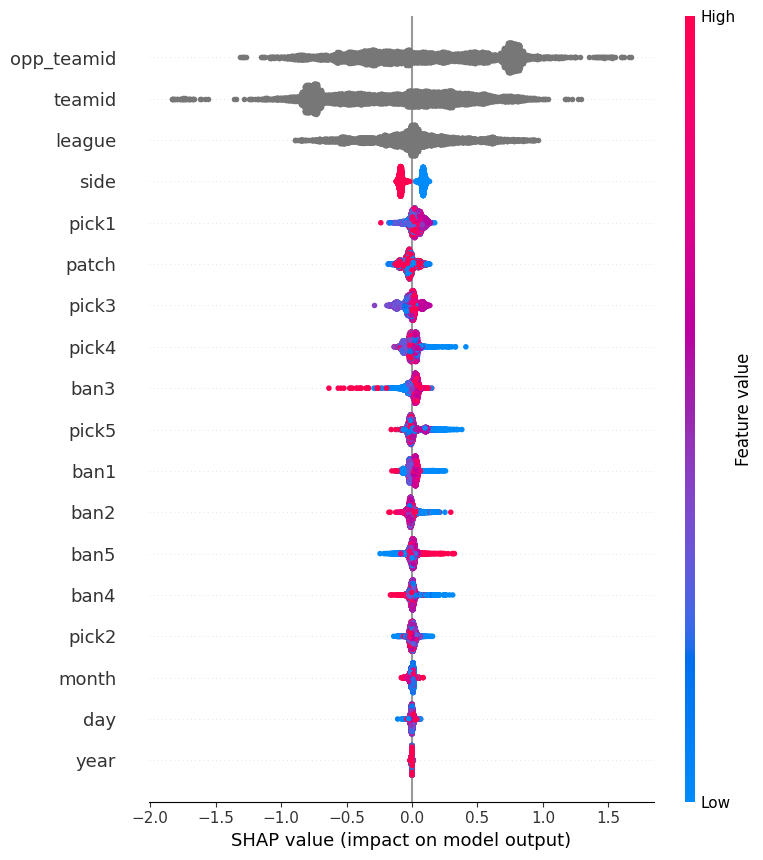

In [25]:
import shap

explainer = shap.TreeExplainer(catboost)
shap_values = explainer.shap_values(valid_x)

shap.summary_plot(shap_values, valid_x)